<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/aet_pytorch/aet_2lay_lin_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!git clone https://github.com/katduecker/dnn_osci
%cd dnn_osci
%cd aet_pytorch/

fatal: destination path 'dnn_osci' already exists and is not an empty directory.


In [30]:
# AETZ model replication using pytorch

import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

import aet_net_2lay
import aet_dyn
import aet_net
# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [105]:
# Dynamics

# forward dynamics/discretization, euler integration
def euler_dyn(model,input_,params_,t_,alpha_params,DEVICE,inp_on):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,R,T,h_start,R_start = params_


    # alpha frequency & amplitude
    _af,_aa, _ap = alpha_params

    with torch.no_grad():

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dh1dt = (torch.zeros((model.dims[1],len(t_)+1))*h_start).to(DEVICE)
        dR1dt = (torch.zeros((model.dims[1],len(t_)+1))*R_start).to(DEVICE)
        dh2dt = (torch.zeros((model.dims[2],len(t_)+1))*h_start).to(DEVICE)
        dR2dt = (torch.zeros((model.dims[2],len(t_)+1))*R_start).to(DEVICE)
        dOdt = (torch.zeros((model.dims[-1],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)

        # alpha inhibition
        alpha_inh1 = _aa[0]*np.sin(2*np.pi*_af*t_+_ap[0])+_aa[0]
        alpha_inh2 = _aa[1]*np.sin(2*np.pi*_af*t_+_ap[1])+_aa[1]

        # preactivation (dot product of input and first weight matrix)
        Z,H1,_,_ = model.forw_conv(input_)

        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        # adjust initial adaptation term (threshold)
        dR1dt[:,0] = R_start
        #dR2dt *= torch.max(H1)

        # scale for adaptation
        rsc1 = R*torch.max(Z).detach()
        rsc2 = R*torch.max(H1).detach()

        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z,_,_,_ = model.forw_conv(input_*boxcar[_it])

            # pre-activation
            dZdt[:,_it+1] = (Z + dh1dt[:,_it] - dR1dt[:,_it] - alpha_inh1[_it])/T

            # dynamics hidden layer1
            dh1dt[:,_it+1] = dh1dt[:,_it] + dt/tau_h * (-dh1dt[:,_it] + aet_net_2lay.sigmoid(dZdt[:,_it+1],model.sig_param[0]))

            # adaptation term 1
            dR1dt[:,_it+1] = dR1dt[:,_it] + dt/tau_R * (-dR1dt[:,_it] + rsc1*dh1dt[:,_it+1])

            # pre-activation layer 2
            Z2 = (model.fc1(dh1dt[:,_it+1]) + dh2dt[:,_it+1] - dR2dt[:,_it]- alpha_inh2[_it])/T
            # dynamics hidden layer1
            dh2dt[:,_it+1] = dh2dt[:,_it] + dt/tau_h * (-dh2dt[:,_it] + aet_net_2lay.sigmoid(Z2,model.sig_param[1]))

            # # adaptation term 2
            dR2dt[:,_it+1] = dR2dt[:,_it] + dt/tau_R * (-dR2dt[:,_it] + rsc2*dh2dt[:,_it+1])

            # output layer
            dOdt[:,_it+1] = model.actiout(model.fc2(dh2dt[:,_it+1]))

    return dZdt, dh1dt, dR1dt, dh2dt, dR2dt,dOdt


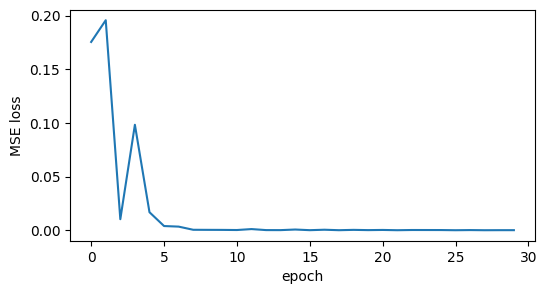

In [38]:
# train 2 layer network
nn_dim_= [28,24,12,3] # # [quadrant size, number of hidden nodes layer 1,number of hidden nodes layer 2, number of output nodes]
# nn_dim_ = [28,24,12,3]
eta_ = 1e-2      # learning rate 0.02 -> smooth loss
mini_sz_ = 1        # mini batch size (1 = use SGD)
num_epo_ = 30

kl_reg_ = [0,1e-3,2]      # beta, p and sparsity layer that is penalized (if beta = 0 -> no penalty)

sig_param = [[2, -2.5],[2,-2.5]] # sigmoid slope and shift in x direction

# orthogonality penality (if lambda = 0, no penalty)
ortho_lambda = 0
ortho_lay = 2 # layer in which to apply ortho penalty

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]


params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lambda, ortho_lay

# initialize model and weights
model = aet_net_2lay.net(params,lossfun)
# initialize weights
model = aet_net_2lay.init_params(model,weight_init='uni')

# select optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=eta_)

# train model
model.to(DEVICE)
loss_hist = model.train(optimizer,noise=False,print_loss=False)


plt.rcParams["figure.figsize"] = (6,3)

%matplotlib inline
plt.plot(np.arange(model.num_ep),loss_hist.detach().numpy())
plt.ylabel('MSE loss')
plt.xlabel('epoch')

plt.show()

In [41]:
data, output = aet_net_2lay.aet_stim.mkstim(False)




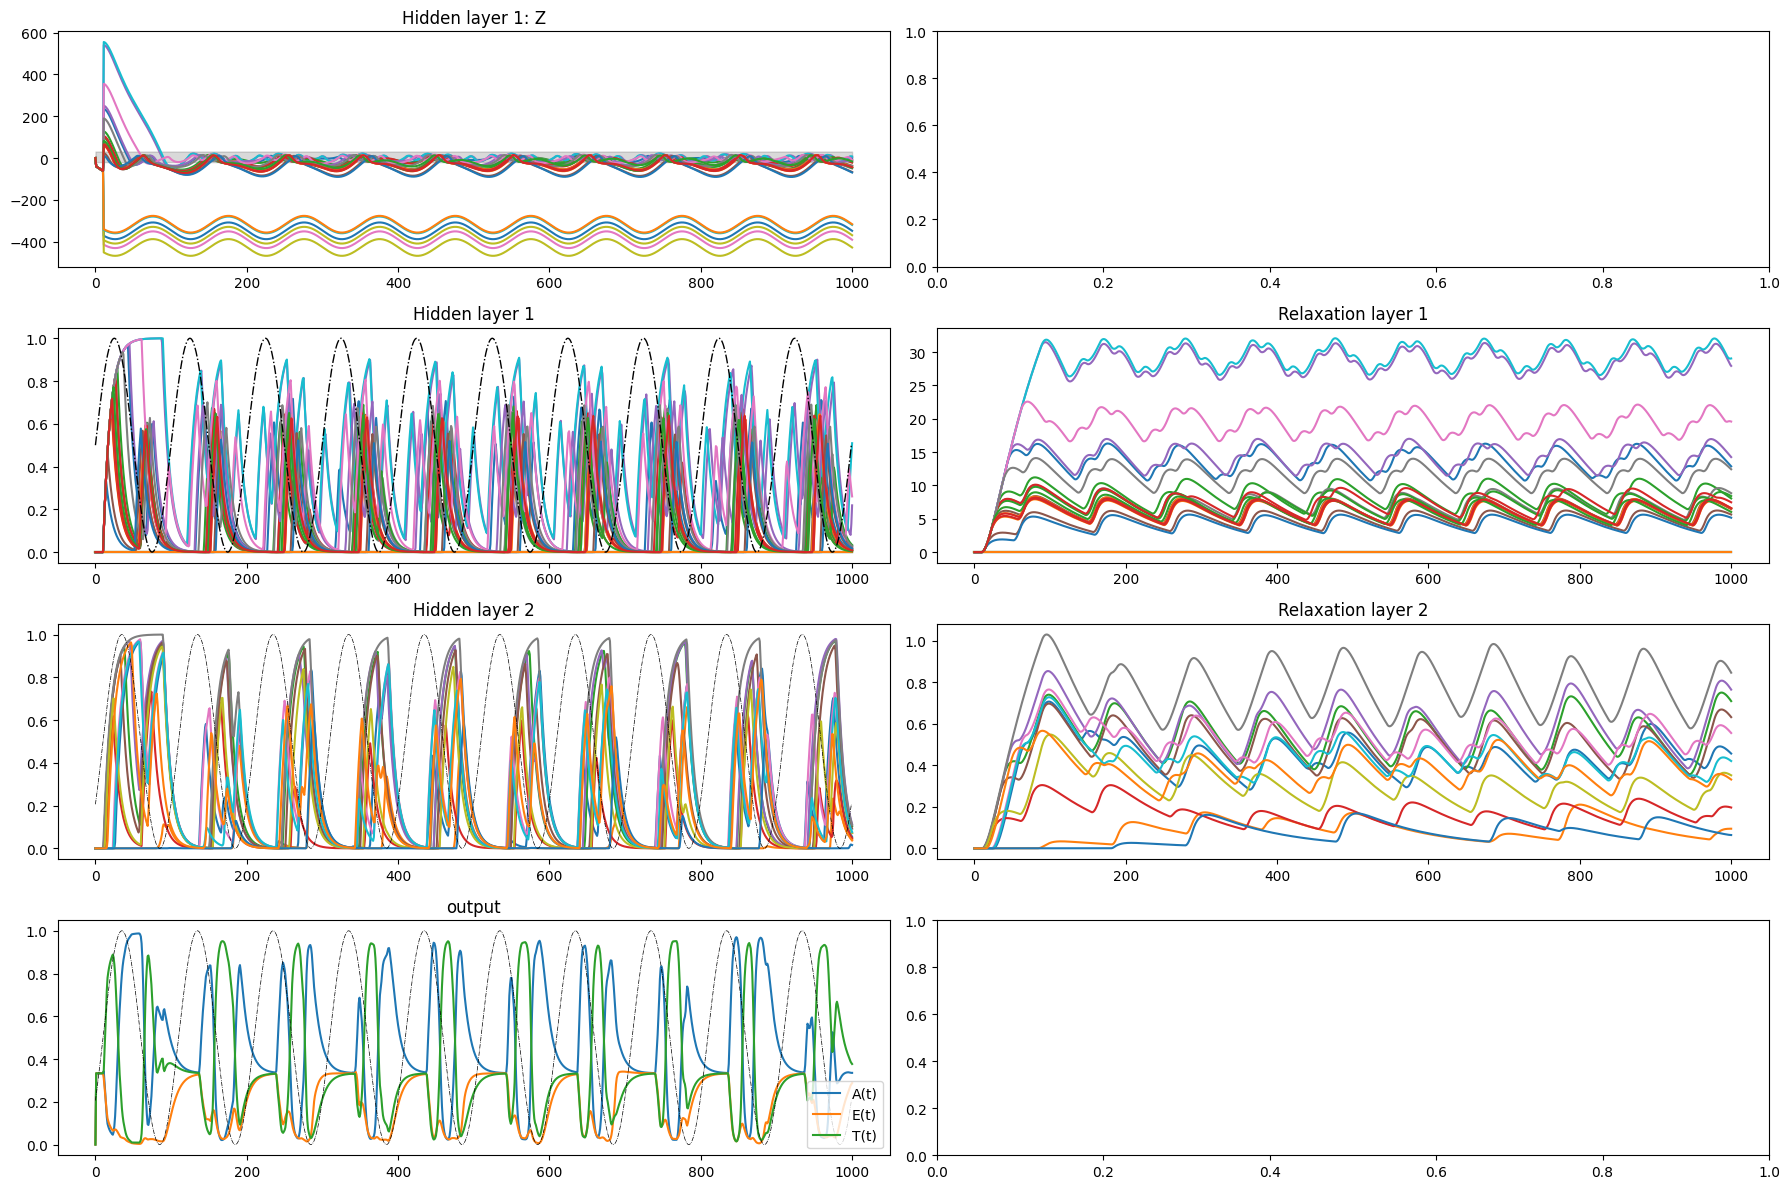

In [107]:
# input to dynamical system
inp = data[[0]]*1.2 + data[[-1]]

# temp dynamics parameters
tau_h = 0.01
tau_R = 0.1
c = 2
S = 0.05
h_start = 0
R_start = 0
timevec = np.linspace(0,1,1000)

alpha_params = [10,[2,0.5],[0,-2*np.pi/10]] # [frequency, [amplitude layer 1, amplitude layer 2],[phase shift layer 1, phase shift layer 2]]

dyn_params = [tau_h,tau_R,c,S,h_start,R_start]

start_dyn_after = 10        # wait this time before starting dynamics (in ms)

Zt_, H1t_, R1t_, H2t_, R2t_, Ot_ = euler_dyn(model,inp, dyn_params,timevec,alpha_params,DEVICE,start_dyn_after)

plt.rcParams["figure.figsize"] = (18,12)


# this is a bit stupi
fig,ax = plt.subplots(4,2)
# layer 1 Z

# get non-dynamic activations for ticks
Z,_,_,_ = model.forw_conv(inp)



ax[0,0].fill_between(np.arange(Zt_.shape[1]), np.tile(np.min(Z.detach().numpy()),Zt_.shape[1]), np.tile(np.max(Z.detach().numpy()),Zt_.shape[1]), alpha=0.15, color=[0, 0, 0])
ax[0,0].plot(Zt_.T)
ax[0,0].set_title('Hidden layer 1: Z')

# layer 1 H
ax[1,1].plot(R1t_.T.cpu().detach().numpy())
ax[1,1].set_title('Relaxation layer 1')
ax[1,0].plot(H1t_.T.cpu().detach().numpy())
ax[1,0].set_title('Hidden layer 1')

# layer 2
ax[2,1].plot(R2t_.T.cpu().detach().numpy())
ax[2,1].set_title('Relaxation layer 2')
ax[2,0].plot(H2t_.T.cpu().detach().numpy())
ax[2,0].set_title('Hidden layer 2')

# output layer
ax[3,0].plot(Ot_.T.cpu().detach().numpy())
ax[3,0].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[3,0].set_title('output')


# add alpha to plot
if alpha_params[1][0] > 0:
    alpha_inh = 0.5*np.sin(2*np.pi*timevec*10+alpha_params[2][0])+0.5
    ax[1,0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')

if alpha_params[1][1]:
    alpha_inh2 = 0.5*np.sin(2*np.pi*timevec*10+alpha_params[2][1])+0.5

    ax[3,0].plot(alpha_inh2,'k',linewidth=0.5,linestyle='-.')
    ax[2,0].plot(alpha_inh2,'k',linewidth=0.5,linestyle='-.')



%matplotlib inline
fig.tight_layout()


In [97]:
alpha_params[1][0] > 0

True